# 트랜스포머로 한국어 챗봇을 만들어 보자!

## import library

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 데이터 가져오기


https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv

In [2]:
!ls ~/aiffel/transformer_chatbot/data/

'ChatbotData .csv'   ChatbotData.csv


In [3]:
data_path = os.environ.get("HOME") + "/aiffel/transformer_chatbot/data/ChatbotData.csv"
df_data = pd.read_csv(data_path)
df_data = df_data[['Q','A']]
df_data

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.
...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.
11820,흑기사 해주는 짝남.,설렜겠어요.
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.


In [4]:
df_data.isnull().sum()

Q    0
A    0
dtype: int64

결측치는 없음.

Q와 A가 모두 중복인 경우 확인

In [5]:
duplicates = df_data[df_data.duplicated( keep=False)]
duplicates.sort_values(by=['Q','A'])

,Q,A
152,결혼이나 하지 왜 자꾸 나한테 화 내냐구!,힘들겠네요.
5527,결혼이나 하지 왜 자꾸 나한테 화 내냐구!,힘들겠네요.
189,고백하고 후회하면 어떡하지,후회는 후회를 낳을뿐이에요. 용기 내세요.
5537,고백하고 후회하면 어떡하지,후회는 후회를 낳을뿐이에요. 용기 내세요.
226,공부는 내 체질이 아닌 것 같아,확신이 없나봐요.
...,...,...
8780,회사 사람들이 아직도 불편해,회사에는 동료가 있을 뿐이에요.
5232,회사에는 왜 친구 같은 사람이 없을까,회사는 친구 사귀는 곳이 아니에요.
8782,회사에는 왜 친구 같은 사람이 없을까,회사는 친구 사귀는 곳이 아니에요.
5246,후련하달까,후련하니 다행이에요.


Q,A 모두 중복인 데이터가 73개 존재한다

In [6]:
# Q와 A 모두 중복인 경우 마지막 행을 drop
df_unique = df_data.drop_duplicates(keep='first')

In [7]:
# 확인
df_unique[df_unique.duplicated( keep=False)].sort_values(by=['Q'])

,Q,A


In [8]:
print("중복 제거 전: ",df_data.shape)
print("중복 제거 후: ",df_unique.shape)

중복 제거 전:  (11823, 2)
중복 제거 후:  (11750, 2)


## 전처리

- 영문자열도 그대로 사용하기 위해 소문자로 변경
- 단어와 구두점 사이 거리 두기(구두점 그대로 사용)
- 연속된 공백 -> 하나의 공백
- (a-z, A-Z,0-9, 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체 **숫자, 한글 추가**
- 양쪽 공백 제거

In [9]:
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()    

    # 단어와 구두점 사이 거리 두기
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # 연속된 공백 -> 하나의 공백
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, 0-9, 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r'[^a-zA-Z0-9가-힣\.\?\!\,]', ' ', sentence)
    
    # 양쪽 공백 제거
    sentence = sentence.strip()
    return sentence

In [10]:
df_preprocessed = pd.DataFrame()

In [11]:
df_preprocessed['Q'] = df_unique['Q'].apply(preprocess_sentence)
df_preprocessed['A'] = df_unique['A'].apply(preprocess_sentence)

In [12]:
df_preprocessed

,Q,A
0,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,ppl 심하네,눈살이 찌푸려지죠 .
...,...,...
11818,훔쳐보는 것도 눈치 보임 .,티가 나니까 눈치가 보이는 거죠 !
11819,훔쳐보는 것도 눈치 보임 .,훔쳐보는 거 티나나봐요 .
11820,흑기사 해주는 짝남 .,설렜겠어요 .
11821,힘든 연애 좋은 연애라는게 무슨 차이일까 ?,잘 헤어질 수 있는 사이 여부인 거 같아요 .


2	3박4일 놀러가고 싶다	여행은 언제나 좋죠 .  
3	3박4일 정도 놀러가고 싶다	여행은 언제나 좋죠 .  
  
  
11818	훔쳐보는 것도 눈치 보임 .	티가 나니까 눈치가 보이는 거죠 !    

11819	훔쳐보는 것도 눈치 보임 .	훔쳐보는 거 티나나봐요 .  
  
**의미가 비슷한 행에 대해서는 어떻게 처리해야 할지 고민됨** => *Q로만 중복 제거, A로만 중복 제거 (언어의 미묘한 어감, 어투 차이에 대한 정보를 잃지 않을까?)*

Numpy 배열로 변환

In [13]:
questions = df_preprocessed['Q'].values
answers = df_preprocessed['A'].values

In [14]:
print(questions.shape)
print(type(questions))
print(questions[0])
print(answers.shape)
print(type(answers))
print(answers[0])

(11750,)
<class 'numpy.ndarray'>
12시 땡 !
(11750,)
<class 'numpy.ndarray'>
하루가 또 가네요 .


## 토크나이징

In [15]:
import tensorflow_datasets as tfds

# SubwordTextEncoderfh 토크나이징, questions와 answers를 더한 말뭉치를 기반으로 학습하여 토크나이징
# 토큰의 갯수는 2**13 = 8192개 를 만들도록 시도
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions+answers, target_vocab_size=2**13)

In [16]:
# start_token, end_token 추가; 위에서 8192[0~8191]개의 토큰이 생성을 시도했고, 
# 그 다음 인텍스로 start_token, end_token을 지정
# []를 추가하는 이유? 토큰 시퀀스와 +연산으로 붙이기 편하게 하기 위해(리스트 합)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [17]:
# 2**13개 토큰 시도 결과로 8318개 만들어짐
print("START_TOKEN: ",START_TOKEN)
print("END_TOKEN: ", END_TOKEN)

START_TOKEN:  [8318]
END_TOKEN:  [8319]


In [18]:
# 단어장 크기 설정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8320


In [19]:
# 토크나이징 확인, 인코딩 확인
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5821, 605, 2491, 4166]
정수 인코딩 후의 21번째 답변 샘플: [2682, 7632, 9, 6351, 94, 1]


### 문장 길이 분포 확인

질문의 최소 길이 : 1
질문의 최대 길이 : 16
질문의 평균 길이 : 3.9406808510638296
답변의 최소 길이 : 1
답변의 최대 길이 : 24
답변의 평균 길이 : 4.716595744680851


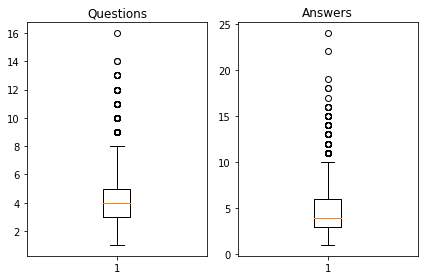

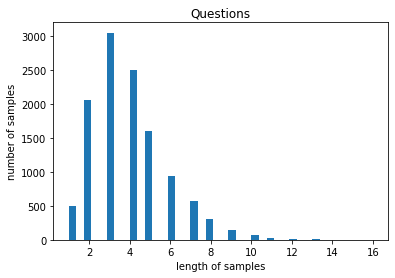

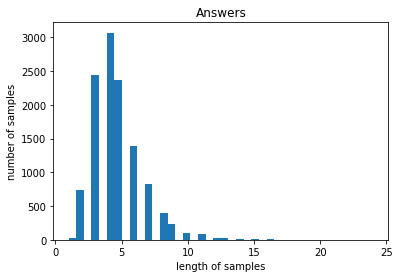

In [20]:
# 혼란한 matplotlib 코드 -> 객체지향적으로 바꿔야 함
# 길이 분포 출력
import matplotlib.pyplot as plt

questions_len= [len(s.split()) for s in questions ]
answers_len = [len(s.split()) for s in answers ]

print('질문의 최소 길이 : {}'.format(np.min(questions_len)))
print('질문의 최대 길이 : {}'.format(np.max(questions_len)))
print('질문의 평균 길이 : {}'.format(np.mean(questions_len)))
print('답변의 최소 길이 : {}'.format(np.min(answers_len)))
print('답변의 최대 길이 : {}'.format(np.max(answers_len)))
print('답변의 평균 길이 : {}'.format(np.mean(answers_len)))

plt.subplot(1,2,1)
plt.boxplot(questions_len)
plt.title('Questions')
plt.subplot(1,2,2)
plt.boxplot(answers_len)
plt.title('Answers')
plt.tight_layout()
plt.show()

plt.title('Questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [22]:
Q_MAX_LENGTH = 8
A_MAX_LENGTH = 10

In [23]:
below_threshold_len(Q_MAX_LENGTH, questions)
below_threshold_len(A_MAX_LENGTH, answers)

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.977872340425532
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.9853617021276596


---

**여기 틀림, 분포 확인은 문자열을 했는데, 아래서는 토큰 갯수로 필터링하기 때문에 틀림** => 나중에 고쳐야 됨

---

질문은 8, 답변은 10으로 사용

In [24]:
# 정수로 인코딩 & q_max_len=8, a_max_len=10 & 패딩 작업
def prepare_tokenized_sequences(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # start_token, end_token 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # q_max_len=8, a_max_len=10 데이터만 사용
        if len(sentence1) <= Q_MAX_LENGTH and len(sentence2) <= A_MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # q -> 8로 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=Q_MAX_LENGTH, padding='post')
    # a -> 10으로 패딩
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=A_MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs


In [25]:
questions, answers = prepare_tokenized_sequences(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8320
필터링 후의 질문 샘플 개수: 7404
필터링 후의 답변 샘플 개수: 7404


데이터 수가 적은 편인것 같음.

데이터 형태 정리
- 인코더 input: sos + ~ + eos
- 디코더 input: sos + ~
- 디코더 output: ~ + eos

In [26]:
# 한 번에 모델에 입력될 데이터 샘플 수: 64개를 한 묶음으로 보고 병렬처리
BATCH_SIZE = 64
# 셔플을 위한 버퍼 크기 전체 데이터 중 BUFFER_SIZE만큼 메모리에 올려서 셔플하겠다는 것; 메모리 사용량 관리 필요
# 총 데이터가 7404개 정도라...그냥 섞는 메모리 공간을 좀 크게 함.
BUFFER_SIZE = 10000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()  # 처음에 메모리에 로딩하고, 이후부터 디스크 I/O 없이 하겠다.
dataset = dataset.shuffle(BUFFER_SIZE)   # 섞어
dataset = dataset.batch(BATCH_SIZE)      # 배치사이즈로 배치 묶음 만들어
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)    # 다음 배치를 백그라운드에서 미리 준비해서 훈련이 끊기지 않도록 함. AUTOTUNE은 TensorFlow가 최적의 prefetch 양을 자동으로 조절해줌 → 성능 최적화


## 모델 구성
트랜스포머: https://arxiv.org/pdf/1706.03762.pdf

In [27]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    """
    위치 정보를 구성.
    임베딩벡터 + '위치정보벡터'
    위치 간 상대적 거리 정보를 담을 수 있어야 함
    벡터 차원이 클수록 다양한 위치 관계를 구별할 수 있어야 함
    다양한 주파수(다양한 거리)를 표현해야 함   
    
    하나의 벡터의 차원마다 주파수가 다르고,
    단어 벡터의 같은 요소 차원(index)은 같은 주파수를 가짐 -> position에 따라 다른 값을 가짐
    """

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    # sin, cos 인자로 들어갈 angle 구함
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    
    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]



In [28]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    """
    query와 key의 내적으로 유사도를 구해 -> 행렬로 나옴(셀프어텐션에서만 정사각행렬임)
    코사인 유사도랑 비슷함
    소프트맥스가 너무 커지지 않기 위해 루트(차원)으로 나누어 줌
    소프트맥스를 통과하고 V를 행렬곱
    """
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += mask * -1e9

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


In [29]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    어텐션을 차원 그룹으로 나누어서 병렬로 수행
    """

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads
        
        # 하나의 입력으로 부터 3개의 표현을 뽑아내기 위해 각각 다른 dense를 사용
        # 입력에 대해서 각각 다른 Dense layer를 통과시켜 서로 다른 관점의 벡터로 선형변환 시킴
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        
        # (batch_size, num_heads, seq_len_q, depth) -> (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs


In [30]:
# 패딩이 어텐션 계산이나 손실 계산에 영향을 주지 않도록 마스킹
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]


In [31]:
# 디코더에서 사용. Q, K 유사도 계산에서, 현재보다 미래 위치 토큰을 가리지 위해 사용.(예측해야 되니까)
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)


In [32]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)



In [33]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(Q_MAX_LENGTH, d_model)(
        embeddings
    )  

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)



In [34]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )

    # 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(
        attention2 + attention1
    )

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )




In [35]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(A_MAX_LENGTH, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )



In [36]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)




In [37]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13727744    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [38]:
# 레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, A_MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)


In [39]:
# 학습률을 train step에 따라 변화를 줌
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)



Text(0.5, 0, 'Train Step')

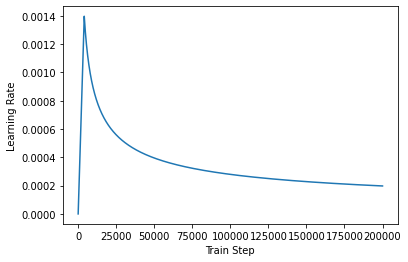

In [40]:
# 커스텀한 학습률 시각화, step_num에 따라 달라짐
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [41]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, A_MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [42]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/100
116/116 [==============================] - 25s 79ms/step - loss: 5.2558 - accuracy: 0.0888
Epoch 2/100
116/116 [==============================] - 9s 80ms/step - loss: 4.3516 - accuracy: 0.1528
Epoch 3/100
116/116 [==============================] - 9s 80ms/step - loss: 3.7465 - accuracy: 0.2144
Epoch 4/100
116/116 [==============================] - 9s 80ms/step - loss: 3.5029 - accuracy: 0.2171
Epoch 5/100
116/116 [==============================] - 9s 81ms/step - loss: 3.3624 - accuracy: 0.2225
Epoch 6/100
116/116 [==============================] - 9s 80ms/step - loss: 3.2638 - accuracy: 0.2262
Epoch 7/100
116/116 [==============================] - 9s 79ms/step - loss: 3.1842 - accuracy: 0.2299
Epoch 8/100
116/116 [==============================] - 9s 79ms/step - loss: 3.0921 - accuracy: 0.2355
Epoch 9/100
116/116 [==============================] - 9s 80ms/step - loss: 2.9756 - accuracy: 0.2429
Epoch 10/100
116/116 [==============================] - 9s 78ms/step - loss: 2.82

In [43]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(A_MAX_LENGTH):
        # 디코더는 최대 A_MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [44]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )

    print("입력 : {}".format(sentence))
    print("출력 : {}".format(predicted_sentence))

    return predicted_sentence


In [45]:
sentence_generation("여행가고 싶어")

입력 : 여행가고 싶어
출력 : 계획을 세워보세요 .


'계획을 세워보세요 .'

In [46]:
sentence_generation("쉬고 싶어")

입력 : 쉬고 싶어
출력 : 내려 놓으세요 .


'내려 놓으세요 .'

In [47]:
sentence_generation("퇴사하고 싶어")

입력 : 퇴사하고 싶어
출력 : 얼른 알아보세요 .


'얼른 알아보세요 .'

In [48]:
sentence_generation("퇴사만세")

입력 : 퇴사만세
출력 : 얼른 주무세요 .


'얼른 주무세요 .'

In [51]:
sentence_generation("퇴사는게 좋을까?")

입력 : 퇴사는게 좋을까?
출력 : 진정하세요 .


'진정하세요 .'

In [53]:
sentence_generation("퇴사해도 될까?")

InvalidArgumentError: required broadcastable shapes [Op:AddV2]

In [49]:
sentence_generation("회사 다니기 싫어")

입력 : 회사 다니기 싫어
출력 : 파이팅 !


'파이팅 !'

In [50]:
sentence_generation("회사 다니고 싶어")

입력 : 회사 다니고 싶어
출력 : 현재를 즐기세요 !


'현재를 즐기세요 !'

In [54]:
sentence_generation("kiwi")

입력 : kiwi
출력 : 정신 차리세요 .


'정신 차리세요 .'

In [55]:
sentence_generation("포도 먹고 싶다")

입력 : 포도 먹고 싶다
출력 : 저랑 한잔 해요 .


'저랑 한잔 해요 .'

In [60]:
sentence_generation("책이 2원이야")

입력 : 책이 2원이야
출력 : 그럴 시기에요 .


'그럴 시기에요 .'

In [57]:
sentence_generation("또 체했네 아휴")

입력 : 또 체했네 아휴
출력 : 또 다시 이땐 생각을 차리세요 .


'또 다시 이땐 생각을 차리세요 .'

# 회고
충분한 epoch으로 학습해야 한다.  
질문 토큰 갯수를 너무 적게 해서, 긴 문장을 질문하면 에러가 발생한다.  
더 많은 데이터를 넣으면 어떻게 될지 궁금하다.    
데이터가 없는 문장에 대해서는 좋은 답변이 나오지 않는 것 같다   
숫자, 영어에 대한 처리도 가능한 것 같다   